In [1]:
##############################################################################
# blosc2_grok: Grok (JPEG2000 codec) plugin for Blosc2
#
# Copyright (c) 2023  Blosc Development Team <blosc@blosc.org>
# https://blosc.org
# License: GNU Affero General Public License v3.0 (see LICENSE.txt)
##############################################################################

"""
Benchmark for compressing blocked images with grok codec.

Data can be downloaded from: http://www.silx.org/pub/nabu/data/compression/lung_raw_2000-2100.h5
"""

'\nBenchmark for compressing blocked images with grok codec.\n\nData can be downloaded from: http://www.silx.org/pub/nabu/data/compression/lung_raw_2000-2100.h5\n'

In [2]:
from time import time

import blosc2_grok
import h5py
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm

import blosc2

print(f"Blosc2 version: {blosc2.__version__}")
print(f"blosc2_grok version: {blosc2_grok.__version__}")

Blosc2 version: 2.5.1
blosc2_grok version: 0.2.2


In [3]:
# Params for the frame iterator
verbose = False
all_frames = False
meas = {}  # dictionary for storing the measurements

In [4]:
# Open the dataset
data_dir = '/home/faltet/Downloads/'
f = h5py.File(f'{data_dir}/lung_raw_2000-2100.h5', 'r')
dset = f['/data']
if all_frames:
    nframes = dset.shape[0]
else:
    nframes = 1
#images_per_chunk = 16
images_per_chunk = 8
nimages = images_per_chunk
blocks = (1, dset.shape[1], dset.shape[2])
print(f"Compressing dataset of {dset.shape} images ...")

Compressing dataset of (100, 1024, 2048) images ...


In [5]:
# Define the compression and decompression parameters for Blosc2.
# Disable the filters and the splitmode, because these don't work with grok.
cparams = {
    'codec': blosc2.Codec.GROK,
    #'nthreads': 16,  # when commented out, this is automatically set to the number of cores
    'filters': [],
    'splitmode': blosc2.SplitMode.NEVER_SPLIT,
}
dparams = {
    'nthreads': 4,
}

# Set the default parameters that will be used by grok
grok_params = {
    'cod_format': blosc2_grok.GrkFileFmt.GRK_FMT_JP2,
    'num_threads': 0,
}

In [6]:
def iter_images(verbose=False):
    # ret = itertools.chain([1], range(4, images_per_chunk + 1, 4))
    ret = range(8, images_per_chunk + 1, 4)
    if verbose:
        ret = tqdm(ret)
    return ret

In [7]:
# Compress the dataset with different compression ratios
quality_mode = "grok-rates"
print(f"Quality mode: {quality_mode}")
ssims = []
cratios = []
times = []
dtimes = []
range_vals = list(range(1, 11))
range_vals_str = "range(1, 11)"
for cratio in range_vals:
    if verbose:
        print(f"Compressing with cratio={cratio}x ...")
    blosc2_grok.set_params_defaults(
        quality_mode="rates",
        quality_layers=np.array([cratio], dtype=np.float64),
        **grok_params)

    # Iterate over the frames
    iter_frames = tqdm(range(0, nframes, nimages)) if verbose else range(0, nframes, nimages)
    for i in iter_frames:
        im = dset[i:i+nimages, ...]
        # Transform the numpy array into a blosc2 array. This is where compression happens.
        t0 = time()
        chunks = (nimages, dset.shape[1], dset.shape[2])
        b2im = blosc2.asarray(im, chunks=chunks, blocks=blocks, cparams=cparams)
        if i == 0:
            times.append(time() - t0)
            cratios.append(b2im.schunk.cratio)
            # Compare with the original image
            t0 = time()
            im2 = b2im[:]
            dtimes.append(time() - t0)
            ssim_ = ssim(im[0], im2[0], data_range=im[0].max() - im[0].min())
            ssims.append(ssim_)
    if verbose:
        print(f"SSIM: {ssim_}")
meas[quality_mode] = {'ssims': ssims, 'cratios': cratios, 'times': times, 'dtimes': dtimes}

Quality mode: grok-rates


In [8]:
for shuffle in ("shuffle", "bitshuffle", "bytedelta"):
    if shuffle == "bytedelta":
        shuffle_mode = blosc2.Filter.BYTEDELTA
    elif shuffle == "shuffle":
        shuffle_mode = blosc2.Filter.SHUFFLE
    else:
        shuffle_mode = blosc2.Filter.BITSHUFFLE
        
    # Compress the dataset with different compression ratios
    quality_mode = f"itrunc16-{shuffle}-zstd5"
    print(f"Quality mode: {quality_mode}")
    ssims = []
    cratios = []
    times = []
    dtimes= []
    range_vals = list(range(15, 5, -1))
    range_vals_str = "range(15, 5, -1)"
    for nbits in range_vals:
        if verbose:
            print(f"Compressing with itrunc={nbits}x ...")
        cparams2 = blosc2.cparams_dflts.copy()
        cparams2['codec'] = blosc2.Codec.ZSTD
        cparams2['clevel'] = 5
        cparams2['filters'] = [blosc2.Filter.INT_TRUNC, shuffle_mode]
        cparams2['filters_meta'] = [nbits, 1]
    
        # Iterate over the frames
        iter_frames = tqdm(range(0, nframes, nimages)) if verbose else range(0, nframes, nimages)
        for i in iter_frames:
            im = dset[i:i+nimages, ...]
            # Transform the numpy array into a blosc2 array. This is where compression happens.
            t0 = time()
            chunks = (nimages, dset.shape[1], dset.shape[2])
            b2im = blosc2.asarray(im, chunks=chunks, blocks=blocks, cparams=cparams2)
            if i == 0:
                times.append(time() - t0)
                cratios.append(b2im.schunk.cratio)
                # Compare with the original image
                t0 = time()
                im2 = b2im[:]
                dtimes.append(time() - t0)
                ssim_ = ssim(im[0], im2[0], data_range=im[0].max() - im[0].min())
                ssims.append(ssim_)
        if verbose:
            print(f"SSIM: {ssim_}")
    meas[quality_mode] = {'ssims': ssims, 'cratios': cratios, 'times': times, 'dtimes': dtimes}

Quality mode: itrunc16-shuffle-zstd5
Quality mode: itrunc16-bitshuffle-zstd5
Quality mode: itrunc16-bytedelta-zstd5


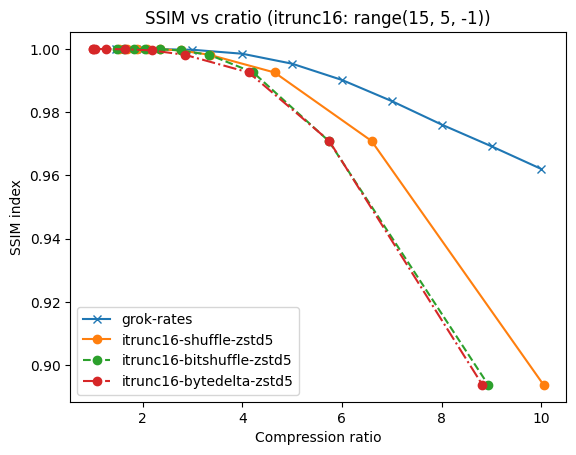

In [9]:
for quality_mode in ["grok-rates", "itrunc16-shuffle-zstd5", "itrunc16-bitshuffle-zstd5", "itrunc16-bytedelta-zstd5"]:
    if quality_mode == "grok-rates":
        marker = 'x-'
    elif quality_mode == "itrunc16-shuffle-zstd5":
        marker = 'o-'
    elif quality_mode == "itrunc16-bitshuffle-zstd5":
        marker = 'o--'
    else:
        marker = 'o-.'
    plt.plot(meas[quality_mode]['cratios'], meas[quality_mode]['ssims'], marker, label=quality_mode)
plt.title(f'SSIM vs cratio ({quality_mode.split("-")[0]}: {range_vals_str})')
plt.xlabel('Compression ratio')
plt.ylabel('SSIM index')
plt.legend()

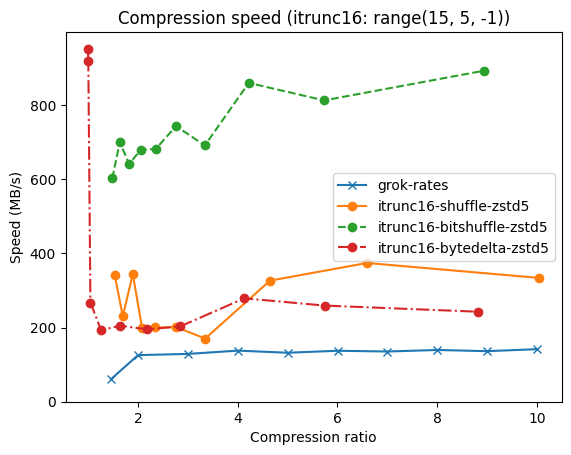

In [10]:
chunks = (images_per_chunk, dset.shape[1], dset.shape[2])
sizeMB = np.prod(chunks) / 2**20
for quality_mode in ["grok-rates", "itrunc16-shuffle-zstd5", "itrunc16-bitshuffle-zstd5", "itrunc16-bytedelta-zstd5"]:
    if quality_mode == "grok-rates":
        marker = 'x-'
    elif quality_mode == "itrunc16-shuffle-zstd5":
        marker = 'o-'
    elif quality_mode == "itrunc16-bitshuffle-zstd5":
        marker = 'o--'
    else:
        marker = 'o-.'
    plt.plot(meas[quality_mode]['cratios'], sizeMB / meas[quality_mode]['times'], marker, label=quality_mode)

plt.title(f'Compression speed ({quality_mode.split("-")[0]}: {range_vals_str})')
plt.xlabel('Compression ratio')
plt.ylabel('Speed (MB/s)')
plt.ylim(0)
plt.legend()

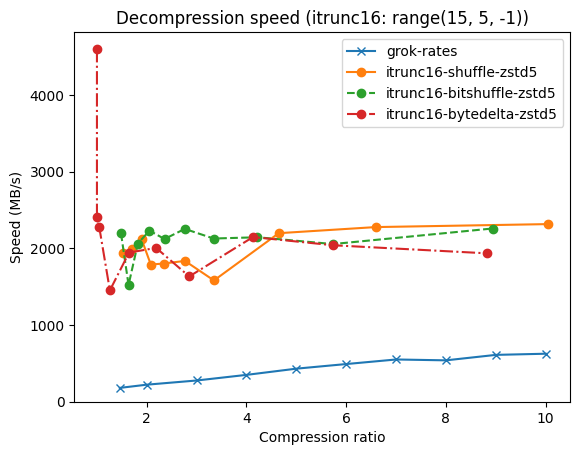

In [11]:
chunks = (images_per_chunk, dset.shape[1], dset.shape[2])
sizeMB = np.prod(chunks) / 2**20
for quality_mode in ["grok-rates", "itrunc16-shuffle-zstd5", "itrunc16-bitshuffle-zstd5", "itrunc16-bytedelta-zstd5"]:
    if quality_mode == "grok-rates":
        marker = 'x-'
    elif quality_mode == "itrunc16-shuffle-zstd5":
        marker = 'o-'
    elif quality_mode == "itrunc16-bitshuffle-zstd5":
        marker = 'o--'
    else:
        marker = 'o-.'
    plt.plot(meas[quality_mode]['cratios'], sizeMB / meas[quality_mode]['dtimes'], marker, label=quality_mode)

plt.title(f'Decompression speed ({quality_mode.split("-")[0]}: {range_vals_str})')
plt.xlabel('Compression ratio')
plt.ylabel('Speed (MB/s)')
plt.ylim(0)
plt.legend()